Python 版本: 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
NumPy 版本: 1.20.3
pandas 版本: 2.0.3
XGBoost 已安装

生成模拟数据...
生成数据完成，共200000条记录
数据示例：
   user_id   datetime event_type  product_id
0     7271 2023-06-14       view      4215.0
1      861 2023-06-12       view      2571.0
2     5391 2023-06-26       view      3132.0
3     5192 2023-06-28       view      1098.0
4     5735 2023-06-07       cart      1573.0

数据预处理...
删除重复记录: 200000 → 199991 (删除了 9 条)

特征工程...
观察截止日期: 2023-06-23
总用户数: 10000

特征数据集示例：
         total_visits  active_days  purchase_rate  days_since_last  \
user_id                                                              
7271               13           10       0.076923                2   
861                16           10       0.062500                2   
5391               16           12       0.312500                0   
5192               15           10       0.333333                1   
5735               14           11       0.071429        

AttributeError: module 'seaborn' has no attribute 'histplot'

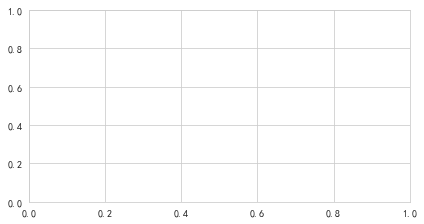

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# 创建目录保存图表
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 显示版本信息
print(f"Python 版本: {sys.version}")
print(f"NumPy 版本: {np.__version__}")
print(f"pandas 版本: {pd.__version__}")

# 尝试导入XGBoost，如果失败则使用备选方案
try:
    from xgboost import XGBClassifier
    xgb_available = True
    print("XGBoost 已安装")
except ImportError:
    print("XGBoost 未安装，将使用随机森林和逻辑回归")
    from sklearn.ensemble import GradientBoostingClassifier
    xgb_available = False

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子保证可复现性
np.random.seed(42)

# ======================
# 1. 模拟数据生成
# ======================
print("\n生成模拟数据...")
n_users = 10000
n_records = 200000

# 生成用户ID
user_ids = np.random.randint(1, n_users + 1, n_records)

# 生成行为时间（最近30天内）
base_date = datetime(2023, 6, 1)
event_dates = [base_date + timedelta(days=np.random.randint(0, 30)) 
               for _ in range(n_records)]

# 创建DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'datetime': event_dates,
    'event_type': np.random.choice(['view', 'cart', 'purchase'], n_records, p=[0.7, 0.2, 0.1]),
    'product_id': np.random.randint(1000, 5000, n_records)
})

# 添加少量缺失值（模拟真实数据）
df.loc[np.random.choice(df.index, size=500, replace=False), 'product_id'] = np.nan
print(f"生成数据完成，共{len(df)}条记录")
print("数据示例：")
print(df.head())

# 可视化1: 事件类型分布
plt.figure(figsize=(10, 6))
event_counts = df['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")
plt.title('事件类型分布')
plt.xlabel('事件类型')
plt.ylabel('数量')
plt.savefig('visualizations/event_type_distribution.png', bbox_inches='tight')
plt.close()

# 可视化2: 每日活动趋势
plt.figure(figsize=(12, 6))
daily_activity = df.set_index('datetime').resample('D').size()
daily_activity.plot()
plt.title('每日活动趋势')
plt.xlabel('日期')
plt.ylabel('活动次数')
plt.savefig('visualizations/daily_activity_trend.png', bbox_inches='tight')
plt.close()

# ======================
# 2. 数据预处理
# ======================
print("\n数据预处理...")

# 处理缺失值
df['product_id'] = df['product_id'].fillna(-1).astype(int)

# 删除重复记录
initial_count = len(df)
df = df.drop_duplicates()
print(f"删除重复记录: {initial_count} → {len(df)} (删除了 {initial_count - len(df)} 条)")

# 可视化3: 缺失值处理前后对比
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('缺失值分布热力图')
plt.savefig('visualizations/missing_values_heatmap.png', bbox_inches='tight')
plt.close()

# ======================
# 3. 特征工程
# ======================
print("\n特征工程...")

# 设置观察点（最后日期前7天）
cutoff_date = df['datetime'].max() - timedelta(days=7)
print(f"观察截止日期: {cutoff_date.date()}")

# 构建特征数据集
feature_data = pd.DataFrame(index=df['user_id'].unique())
feature_data.index.name = 'user_id'
print(f"总用户数: {len(feature_data)}")

# 特征1：总访问次数
pv = df[df['datetime'] <= cutoff_date].groupby('user_id').size()
feature_data['total_visits'] = feature_data.index.map(pv).fillna(0)

# 特征2：活跃天数
active_days = df[df['datetime'] <= cutoff_date].groupby('user_id')['datetime'].apply(
    lambda x: x.dt.date.nunique()
)
feature_data['active_days'] = feature_data.index.map(active_days).fillna(0)

# 特征3：购买转化率
purchase_count = df[
    (df['event_type'] == 'purchase') & 
    (df['datetime'] <= cutoff_date)
].groupby('user_id').size()
feature_data['purchase_rate'] = feature_data.index.map(purchase_count).fillna(0) / feature_data['total_visits']
feature_data['purchase_rate'] = feature_data['purchase_rate'].fillna(0)

# 特征4：最近活跃时间
last_active = df[df['datetime'] <= cutoff_date].groupby('user_id')['datetime'].max()
# 正确计算天数差
def calc_days_since_last(user_id):
    if user_id in last_active:
        return (cutoff_date - last_active[user_id]).days
    return 999  # 如果用户没有活动记录

feature_data['days_since_last'] = feature_data.index.map(calc_days_since_last)

# 特征5：平均访问间隔
def calc_avg_interval(group):
    if len(group) > 1:
        intervals = group.sort_values().diff().dt.total_seconds().dropna()
        return intervals.mean() / 3600  # 转换为小时
    return 0

time_intervals = df[df['datetime'] <= cutoff_date].groupby('user_id')['datetime'].apply(calc_avg_interval)
feature_data['avg_interval_hr'] = feature_data.index.map(time_intervals).fillna(0)

# 特征6：不同商品数量
unique_products = df[df['datetime'] <= cutoff_date].groupby('user_id')['product_id'].nunique()
feature_data['unique_products'] = feature_data.index.map(unique_products).fillna(0)

print("\n特征数据集示例：")
print(feature_data.head())

# 可视化4: 特征分布直方图
plt.figure(figsize=(15, 12))
features_to_plot = ['total_visits', 'active_days', 'purchase_rate', 'days_since_last', 'avg_interval_hr', 'unique_products']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(feature_data[feature], bins=30, kde=True)
    plt.title(f'{feature} 分布')
    plt.xlabel(feature)
    plt.ylabel('频率')

plt.tight_layout()
plt.savefig('visualizations/feature_distributions.png', bbox_inches='tight')
plt.close()

# 可视化5: 特征箱线图
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=feature_data[feature])
    plt.title(f'{feature} 箱线图')

plt.tight_layout()
plt.savefig('visualizations/feature_boxplots.png', bbox_inches='tight')
plt.close()

# ======================
# 4. 标签构建
# ======================
print("\n构建留存标签...")

# 定义留存：未来7天内是否活跃
future_start = cutoff_date + timedelta(days=1)
future_end = cutoff_date + timedelta(days=7)
print(f"留存观察期: {future_start.date()} 至 {future_end.date()}")

future_active_users = df[
    (df['datetime'] >= future_start) & 
    (df['datetime'] <= future_end)
]['user_id'].unique()

feature_data['retention_7d'] = feature_data.index.isin(future_active_users).astype(int)
retention_rate = feature_data['retention_7d'].mean()
print(f"留存率: {retention_rate:.2%}")

# 可视化6: 留存标签分布
plt.figure(figsize=(8, 6))
retention_counts = feature_data['retention_7d'].value_counts()
plt.pie(retention_counts, labels=['未留存', '留存'], autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('7天留存率分布')
plt.savefig('visualizations/retention_distribution.png', bbox_inches='tight')
plt.close()

# 可视化7: 留存用户与非留存用户特征对比
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=feature_data, x=feature, hue='retention_7d', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'留存 vs 未留存: {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.savefig('visualizations/retention_feature_comparison.png', bbox_inches='tight')
plt.close()

# ======================
# 5. 模型训练与评估
# ======================
print("\n模型训练与评估...")

# 划分数据集
X = feature_data.drop('retention_7d', axis=1)
y = feature_data['retention_7d']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 如果XGBoost可用则添加
if xgb_available:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
else:
    # 使用梯度提升作为备选
    models["Gradient Boosting"] = GradientBoostingClassifier(n_estimators=100, random_state=42)

# 训练和评估模型
results = []
for name, model in models.items():
    print(f"\n训练 {name} 模型...")
    # 训练模型
    model.fit(X_train_scaled, y_train)
    
    # 预测
    y_pred = model.predict(X_test_scaled)
    
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # AUC计算（需要概率预测）
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        
        # ROC曲线
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('假正率')
        plt.ylabel('真正率')
        plt.title(f'{name} ROC曲线')
        plt.legend()
        plt.savefig(f'visualizations/roc_curve_{name}.png', bbox_inches='tight')
        plt.close()
        
    except AttributeError:
        auc = 0.5  # 如果模型不支持概率预测
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'{name} 混淆矩阵')
    plt.savefig(f'visualizations/confusion_matrix_{name}.png', bbox_inches='tight')
    plt.close()
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Recall': round(rec, 4),
        'F1': round(f1, 4),
        'AUC': round(auc, 4)
    })
    
    print(f"{name} 评估结果:")
    print(f"  Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# 显示结果
results_df = pd.DataFrame(results)
print("\n模型评估结果汇总：")
print(results_df)

# 可视化8: 模型性能比较
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Recall', 'F1', 'AUC']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df, palette='viridis')
    plt.title(f'模型{metric}比较')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('visualizations/model_performance_comparison.png', bbox_inches='tight')
plt.close()

# ======================
# 6. 特征重要性分析
# ======================
print("\n特征重要性分析：")
if "Random Forest" in models:
    rf_model = models["Random Forest"]
    importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    sorted_importances = importances.sort_values(ascending=False)
    print("随机森林特征重要性:")
    print(sorted_importances.to_string())
    
    # 可视化9: 特征重要性
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='viridis')
    plt.title('随机森林特征重要性')
    plt.xlabel('重要性分数')
    plt.ylabel('特征')
    plt.savefig('visualizations/feature_importance.png', bbox_inches='tight')
    plt.close()
else:
    print("随机森林模型不可用，跳过特征重要性分析")

# 可视化10: 特征相关性热力图
plt.figure(figsize=(12, 8))
corr_matrix = feature_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('特征相关性热力图')
plt.savefig('visualizations/feature_correlation.png', bbox_inches='tight')
plt.close()

# 保存结果
results_df.to_csv('model_results.csv', index=False)
print("\n分析完成！所有图表已保存到 visualizations/ 目录")